# FP reduction DBT challenge.



In [1]:
 import os
 os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
 os.environ['CUDA_VISIBLE_DEVICES']='1'


In [2]:
import gc


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [62]:
from fastai.vision.all import *
from fastai.metrics import error_rate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import fastai; fastai.__version__

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix




ImportError: cannot import name 'loadd_learner' from 'fastai.vision.all' (/home/robert/fastaiv2/install/fastai/fastai/vision/all.py)

In [5]:
torch.cuda.is_available()

True

In [52]:
#!pip list
fastai.__version__

'2.1.8'

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [7]:
bs_1 = 64
bs_2 = 32   # uncomment this line if you run out of memory even after clicking Kernel->Restart
size_1 = 128
size_2 = 256

## data

In [8]:
path ='/home/robert/src/DBT-Duke/dbt2_challenge/debug/rois_f12_8b/'; path
fp_fn = 'results_train_fold12_model1_30k_gray4slices4s_sc0.01_iou0.5.csvfp_red.csv'

### Load CSV for lesion and FP rois

In [9]:
dfTrain = pd.read_csv(path+'/'+fp_fn)


dfTrain.head()


,Unnamed: 0,StudyUID,View,index,PatientID,X,Width,Y,Height,Z,Depth,Score,TP,GTID,filename
0,0,DBT-S00052,rcc,0,DBT-P04750,1572,65,874,55,16,0,0.993908,0,0,DBT-P04750_DBT-S00052_rcc_16_tensor(0.9939).png
1,1,DBT-S00052,rcc,1,DBT-P04750,1846,93,892,82,18,0,0.983922,0,0,DBT-P04750_DBT-S00052_rcc_18_tensor(0.9839).png
2,2,DBT-S00052,rcc,2,DBT-P04750,1433,117,721,59,31,0,0.957851,0,0,DBT-P04750_DBT-S00052_rcc_31_tensor(0.9579).png
3,3,DBT-S00052,rcc,3,DBT-P04750,1039,148,1107,100,39,0,0.144524,0,0,DBT-P04750_DBT-S00052_rcc_39_tensor(0.1445).png
4,4,DBT-S00052,rcc,4,DBT-P04750,1334,165,731,146,6,0,0.060445,1,103,DBT-P04750_DBT-S00052_rcc_6_tensor(0.0604).png


In [10]:
df_fp = dfTrain.loc[dfTrain["TP"] == 0]

print(len(df_fp))

df_tp = dfTrain.loc[dfTrain["TP"] == 1]
print(len(df_tp))
ratio = int(len(df_fp)/len(df_tp))
print('Ratio', ratio-1)

1381
324
Ratio 3


In [11]:
#augmenting 
for i in range(ratio-1):
    dfTrain = dfTrain.append(df_tp)





In [12]:
print(len(dfTrain.loc[dfTrain['TP'] == (0)]))
print(len(dfTrain.loc[dfTrain['TP'] == (1)]))


1381
1296


In [13]:
def get_dls(bs, size,df):
#     tfms = [*aug_transforms(size = size, do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05,\
#         max_warp=0.,pad_mode='reflection', max_rotate=5),Normalize.from_stats(*imagenet_stats)]
    tfms = [*aug_transforms(size = size, do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05,\
        max_warp=0.,pad_mode='reflection', max_rotate=5),Normalize.from_stats(*imagenet_stats)]
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                splitter=RandomSplitter(valid_pct=0.1, seed=None),
                get_x=ColReader("filename", pref=path),
                get_y=ColReader("TP"),
                item_tfms = Resize(512),#600),
                batch_tfms =tfms
                      )                      
    return dblock.dataloaders(df, bs=bs)

In [14]:
np.random.seed(42)



dls = get_dls(64, 224,dfTrain)

# tfms = [*aug_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,\
#      max_warp=0.,pad_mode='reflection', max_rotate=5),Normalize.from_stats(*imagenet_stats)]
# dls = ImageDataLoaders.from_df(df=df,path=path,  convert_mode='L', valid_col='valid', batch_tfms =tfms,
#                               bs = bs, item_tfms = Resize(size = size_1, method ='squish'))

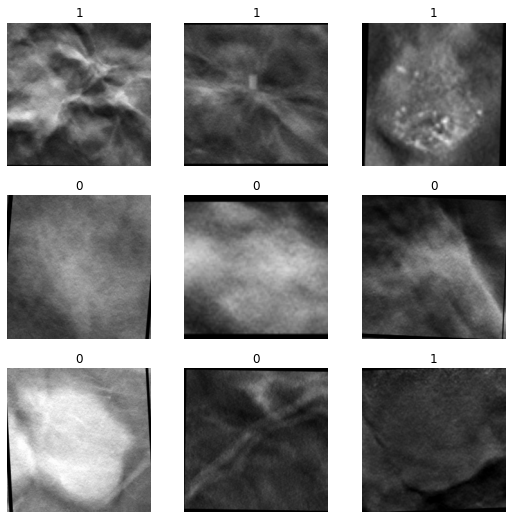

In [15]:

dls.show_batch(cmap='Greys')

In [16]:
len(dls.train_ds)

2410

In [17]:
len(dls.valid_ds)


267

In [18]:
dls.valid_ds


(#267) [(PILImageBW mode=L size=100x79, TensorCategory(1)),(PILImageBW mode=L size=366x352, TensorCategory(1)),(PILImageBW mode=L size=143x190, TensorCategory(1)),(PILImageBW mode=L size=163x148, TensorCategory(1)),(PILImageBW mode=L size=58x45, TensorCategory(0)),(PILImageBW mode=L size=32x57, TensorCategory(0)),(PILImageBW mode=L size=180x149, TensorCategory(1)),(PILImageBW mode=L size=358x319, TensorCategory(1)),(PILImageBW mode=L size=172x157, TensorCategory(0)),(PILImageBW mode=L size=196x239, TensorCategory(0))...]

## learner

In [19]:
torch.cuda.empty_cache()

In [20]:
# weighted cross entropy (be careful with ordering!)
weight = tensor([1.0/ratio, 1.0]).cuda()
# loss_func = torch.nn.CrossEntropyLoss(weight=weight)
# loss_func = torch.nn.CrossEntropyLoss()
# loss_func = CrossEntropyLossFlat(weight=weight)
loss_func = CrossEntropyLossFlat()


In [21]:
dls = get_dls(bs_1,size_1,dfTrain)
model = resnet101(num_classes = 2)
# model = resnet50(num_classes = 2)
# learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), \
learn = Learner(dls, model, loss_func=loss_func, \
                metrics= [accuracy, Precision(average='weighted'), Recall(average='weighted'), error_rate])
# learn = cnn_learner(data, models.resnet18, metrics=accuracy, loss_func=FlattenedLoss(torch.nn.CrossEntropyLoss, weight))
# learn = Learner(dls, model, metrics= [accuracy, Precision(average='weighted'), Recall(average='weighted'), error_rate] \
#                     , loss_func= loss_func)
# learn = Learner(dls, model, metrics= accuracy, loss_func= loss_func)


In [22]:
# learn.lr_find()

In [23]:
learn.fit_one_cycle(100, 3e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.809938,0.694433,0.558052,0.591811,0.558052,0.441948,00:13
1,0.793525,0.930457,0.595506,0.595818,0.595506,0.404494,00:11
2,0.769854,1.379004,0.516854,0.629438,0.516854,0.483146,00:12
3,0.740110,0.778019,0.561798,0.623003,0.561798,0.438202,00:12
4,0.716715,0.706140,0.584270,0.584311,0.584270,0.415730,00:12
5,0.688537,0.768411,0.670412,0.679319,0.670412,0.329588,00:11
6,0.666922,0.747244,0.561798,0.604181,0.561798,0.438202,00:12
7,0.657821,1.494136,0.674157,0.674213,0.674157,0.325843,00:11
8,0.652785,1.175388,0.659176,0.660983,0.659176,0.340824,00:11
9,0.651942,0.602058,0.689139,0.689186,0.689139,0.310861,00:12


In [27]:
preds = learn.get_preds()

threshold = 0.3
preds[0][preds[0][:,1] >threshold]  = 1
preds[0][preds[0][:,1] <threshold]  = 0

preds_y = TensorCategory (preds[0][:,1])


print(len(preds_y))
print(preds_y)
# print(preds[1])

cm = confusion_matrix(preds[1], preds_y)# labels=[
sens = np.zeros(2)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
# sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)
print(cm)

267
TensorCategory([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 

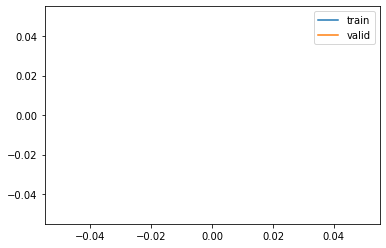

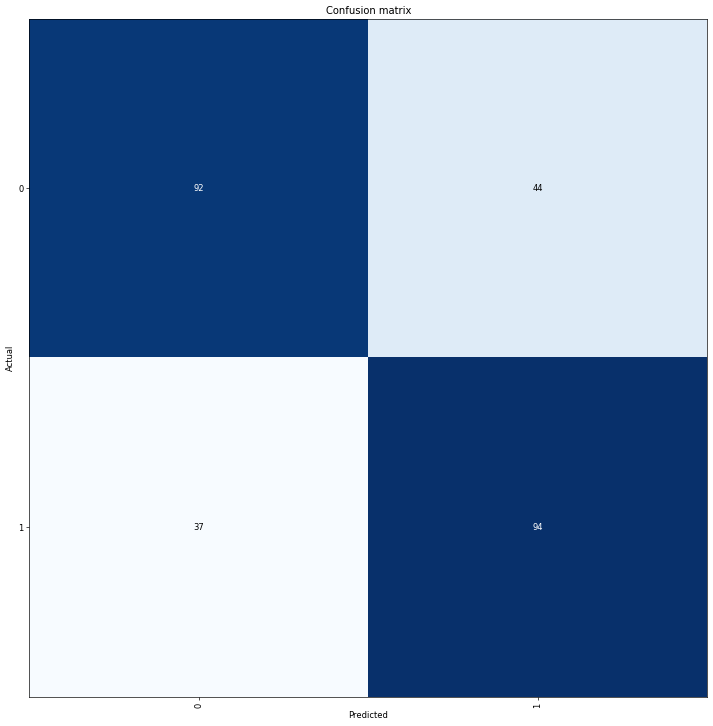

In [28]:
learn.recorder.plot_loss()

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
cm = interp.confusion_matrix()
sens = np.zeros(2)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
# sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

In [ ]:
spec = np.zeros(2)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
# spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

## Increase the size


In [38]:
dls = get_dls(bs_2,size_2,dfTrain)
learn.fit_one_cycle(100,3e-3)
# learn.fit_one_cycle(5, base_lr=3e-4, freeze_epochs=5)
# learn.fine_tune(5, base_lr=3e-3)


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.577230,0.584381,0.670412,0.671034,0.670412,0.329588,00:12
1,0.572676,0.574610,0.696629,0.696598,0.696629,0.303371,00:12
2,0.576007,0.591119,0.677903,0.682005,0.677903,0.322097,00:11
3,0.576761,0.590020,0.670412,0.671835,0.670412,0.329588,00:11
4,0.577221,0.593171,0.670412,0.675244,0.670412,0.329588,00:12
5,0.572232,0.590045,0.704120,0.704614,0.704120,0.295880,00:12
6,0.577568,0.592806,0.677903,0.678033,0.677903,0.322097,00:12
7,0.575067,0.607063,0.674157,0.677067,0.674157,0.325843,00:11
8,0.580248,0.598888,0.674157,0.674630,0.674157,0.325843,00:11
9,0.581295,0.590599,0.704120,0.704098,0.704120,0.295880,00:12


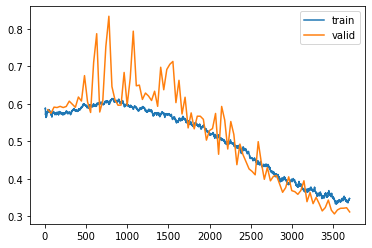

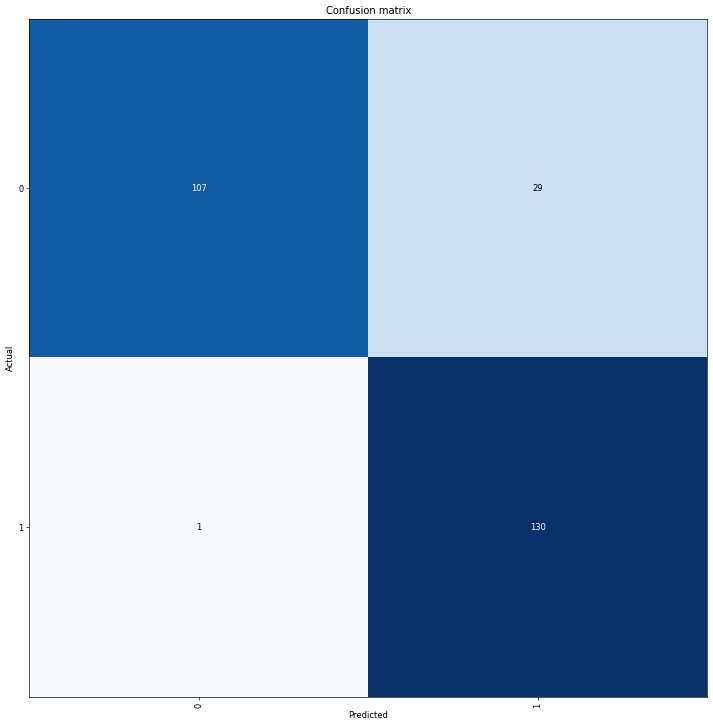

In [39]:
learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [40]:
cm = interp.confusion_matrix()
sens = np.zeros(2)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
# sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.78676471 0.99236641]


In [41]:
spec = np.zeros(2)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
# spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.99074074 0.81761006]


In [46]:
preds = learn.get_preds()

threshold = 0.5
preds[0][preds[0][:,1] >threshold]  = 1
preds[0][preds[0][:,1] <threshold]  = 0

preds_y = TensorCategory (preds[0][:,1])


print(len(preds_y))
print(preds_y)
# print(preds[1])

cm = confusion_matrix(preds[1], preds_y)# labels=[
sens = np.zeros(2)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
# sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)
print(cm)

267
TensorCategory([0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.,
        0., 0., 1., 1., 1., 

## analysis



In [47]:
learn.save('FP_red_101_140_it'+str(size_2)+'-')

Path('models/FP_red_101_140_it256-.pth')

In [48]:
interp.most_confused(min_val=1)

[(0, 1, 29), (1, 0, 1)]

In [ ]:
cm = interp.confusion_matrix()


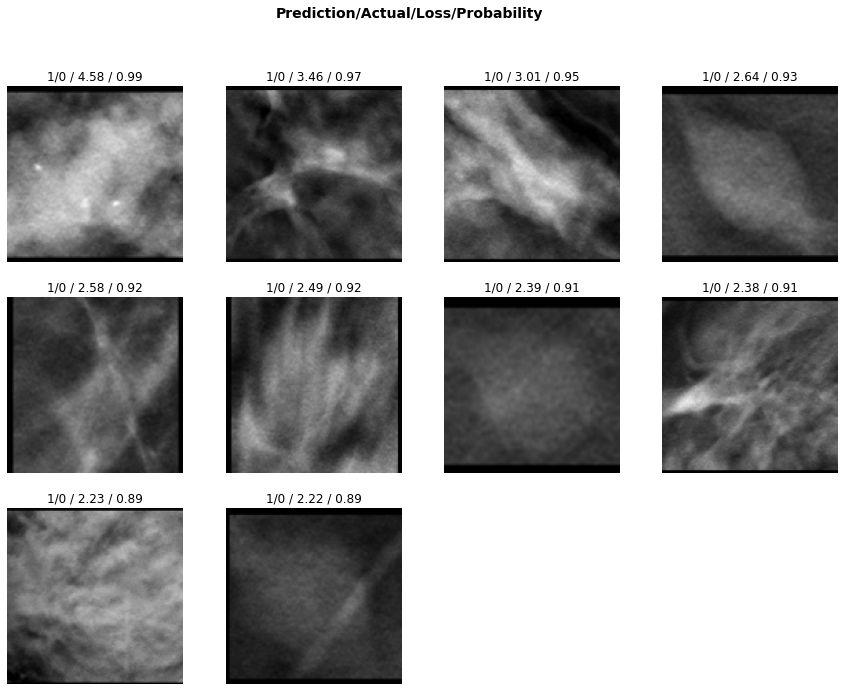

In [49]:
interp.plot_top_losses(10, figsize=(15,11), largest=True)

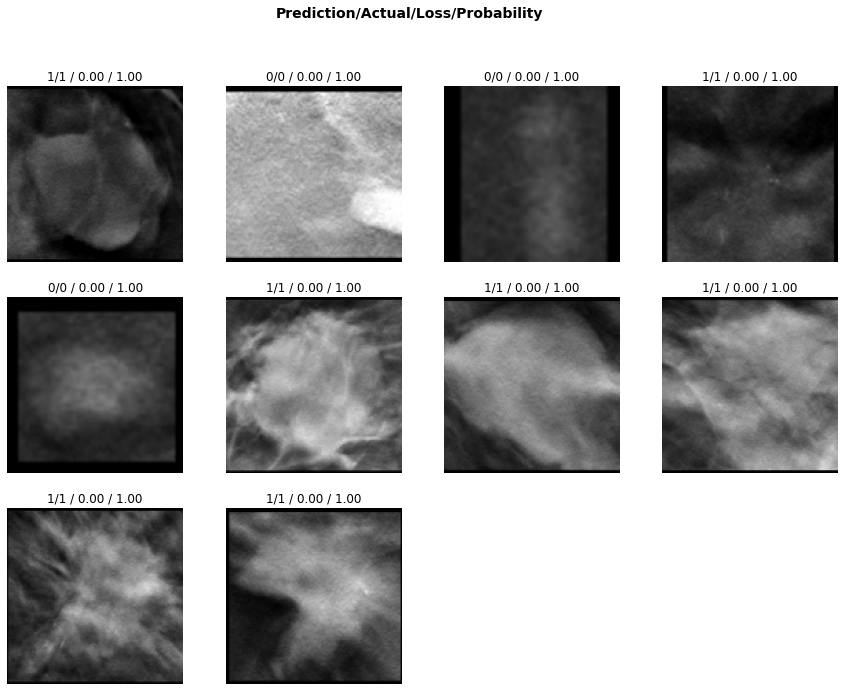

In [50]:
interp.plot_top_losses(10, figsize=(15,11), largest=False)

In [51]:
learn.export('resnet_fp_red_140it_'+str(size_2)+'_export.pkl')

### Test on new data

In [ ]:
learn = load_learner(path+'trainedAllData_resnet_ROI_'+str(size_2)+'_export_v2.pkl', cpu=False)


In [ ]:
# Data from trueta, Tic Salut, Udiat

dfTest = pd.read_csv(path+'covid_local/covid_local_APonly.csv',header=None)
dfTest[0] = 'covid_local/processed/' + dfTest[0].astype(str)

#CSMS (earlier files <20 cases)
dfTest2 = pd.read_csv(path+'CSMS/CSMS.csv',header=None)
dfTest2[0] = 'CSMS/processed/' + dfTest2[0].astype(str)
dfTest2.head()
dfTest = dfTest.append(dfTest2)

# # padchest to include normals and pneumonia (not used for training/validation/testing)
dfTest3 = pd.read_csv(path+'padchest/test_split_np.csv',header=None)
dfTest3[0] = 'padchest/testNP/processed/' + dfTest3[0].astype(str)
dfTest3.head()
dfTest = dfTest.append(dfTest3)

#salutms (120 cases)
dfTest4 = pd.read_csv(path+'salutms/salutms_detect.csv',header=None)
dfTest4[0] = 'salutms/processed/' + dfTest4[0].astype(str)

dfTest = dfTest.append(dfTest4)
# dfTest = dfTest4


print(len(dfTest))
dfTest.head()

In [ ]:
dl = learn.dls.test_dl(dfTest, with_labels= True, device="cuda")
dl.show_batch()

In [ ]:
# preds = learn.get_preds(dl=dl)[0].numpy()
interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
preds = learn.get_preds(dl=dl)
learn.validate(dl=dl)
accuracy(preds[0], preds[1])

In [ ]:
cm = interp.confusion_matrix()


In [ ]:
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

In [ ]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

In [ ]:
# old version.
# log_preds, y = learn.get_preds()

# predIdxs = np.argmax(log_preds.numpy(), axis=1)
# print(exp(log_preds))



In [ ]:
interp.plot_top_losses(25, figsize=(15,11), largest=True)

In [ ]:
interp.plot_top_losses(25, figsize=(15,11), largest=False)